In [1]:
import torch 
import torchvision as tv
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td 
import PIL
from PIL import Image
import os
import scipy
import matplotlib.pyplot as plt
import time
import math
from scipy.linalg import dft 
from os.path import dirname, abspath
from itertools import product
import multiprocessing as MP
import tqdm
    
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from ipynb.fs.defs.denoiser import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
def full_grad(z, MASK, meas):
    # Input: 
    # z, optimization iterate
    # MASK, observed fourier measurements
    # meas, measurements = F(X) + w
    # Output:
    # Full gradient at z

    # real grad
    res = np.fft.fft2(z) * MASK
    index = np.nonzero(MASK)
    res[index] = res[index] - meas[index]
    return np.fft.ifft2(res)


def stoch_grad(z, MASK, meas, ind):
    # Input:
    # z, optimization iterate
    # meas, measurements = F(X) + w
    # batch_index, indices to update
    # Output:
    # stochastic gradient at z for measurements in B

    # batch gradient update
    tmp = np.zeros(z.shape[:2]).astype(float)
    res = np.fft.fft2(z) * MASK
    index = np.nonzero(MASK)
    res[index] = res[index] - meas[index]
    tmp = ind*res
    return np.fft.ifft2(tmp)


def get_batch(B, H, W, N):
    # Input:
    # B, batch size
    # H, image height
    # W, image width
    # N, list of indices
    # Output:
    # batch indices

    #Generate random indices
    tmp = np.random.permutation(N)
    k = tmp[0:B][:]
    batch = np.zeros([H,W])
    batch[k[:,0], k[:,1]] = 1

    # find nonzero batch indices
    return batch

In [3]:
class Algorithm():
    def __init__(self, cnn_name, train_set, val_set, exp_name, device='cuda'):
        np.random.seed(0)
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.denoiser = Denoiser(net=eval(cnn_name)(D=6), 
                                 train_set=train_set, 
                                 val_set=val_set, 
                                 experiment_name=exp_name, 
                                 batch_size=50)
        
        self.net = self.denoiser.net.to(self.device)
        
        data_path="./data/Set12/"
        save_path="./figures/"
        image_list = sorted(os.listdir(data_path))
        ORIG = Image.open(data_path + image_list[12]).resize((256,256))
        ORIG = np.array(ORIG) / 255.0 
        mintmp = np.min(ORIG)
        maxtmp = np.max(ORIG)
        self.original = (ORIG - mintmp) / (maxtmp - mintmp)
        
        # add noise
        prob = .5 
        H, W = ORIG.shape[:2] 
        N = H*W 
        self.sigma = 1.0
        
        self.mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob, prob])
        self.indices = np.transpose(np.nonzero(self.mask))
        
        noises = np.random.normal(0, self.sigma, (H,W))
        forig = np.fft.fft2(ORIG)
        y0 = forig + noises
        self.y = np.multiply(self.mask, y0)
        
        x_init = np.absolute(np.fft.ifft2(self.y))
        mintmp = np.min(x_init)
        maxtmp = np.max(x_init)
        self.noisy = (x_init - mintmp) / (maxtmp - mintmp)
        
        self.patch = dict(patch_size=5, patch_distance=6, multichannel=True)
        
    def display(self, output, title):
        ## Display output of PnP-SVRG algorithm        
        psnr_out = peak_signal_noise_ratio(self.original, output)
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        svrg_plot = plt.imshow(output, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"%s, PSNR = {psnr_out:0.2f}" % title)
        ax.axis('off')
    
    def svrg(self, denoiser, eta, T1, T2, batch_size, FILTER,
             patch, z, MASK, meas, orig):

        ## Obtain info from inputs
        H, W = z.shape[:2] # image dimensions
        index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask

        ## Initialize time-keeping variables
        time_per_iter = []
        psnr_per_iter = []
        t0 = 0

        ## Main PnP SVRG routine
        for i in range(T1):
            # outer loop
            mu = full_grad(z, MASK, meas)   	# Gradient at reference point
            w = np.copy(z) 					# Initialize reference point
            start_iter = time.time()
            for j in range(T2):
                ## inner loop
                ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

                ## calculate stochastic variance-reduced gradient
                v = stoch_grad(z, MASK, meas, ind) - stoch_grad(w, MASK, meas, ind) + mu

                ## take gradient step
                z = z - eta*v

                ## Denoising
                ztilde = np.copy(z)
                
                #import pdb; pdb.set_trace()
                #ztilde = (ztilde - ztilde.min())/(ztilde.max()-ztilde.min())
                
                if denoiser == 'nlm':
                    z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
                elif denoiser == 'cnn':
                    z = self.net(torch.Tensor(abs(z))[None][None].to(self.device)).squeeze().detach().cpu().numpy()                    
                    
                ## Display PSNR at each iteration
                #print(str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))

            ## Calculate time and PSNR difference per outer loop
            stop_iter = time.time()
            time_per_iter.append(stop_iter - start_iter)
            psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

            t0 += 1
        ## Output final iterate, time keeping
        return z, time_per_iter, psnr_per_iter
    
    def gd(self, denoiser, eta, T, FILTER, 
           patch, z, MASK, meas, orig):
        ## Obtain info from inputs
        H, W = z.shape[:2] # image dimensions
        index = self.indices

        ## Initialize time-keeping variables
        time_per_iter = []
        psnr_per_iter = []
        
        t1 = 0

        # Main PnP GD routine
        for i in range(T):
            start_iter = time.time()

            ## Gradient Update
            v = full_grad(z, MASK, meas)
            z = z - eta * v

            # Denoising
            ztilde = np.copy(z)
            
            if denoiser == 'nlm':
                z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            elif denoiser == 'cnn':
                z = self.net(torch.Tensor(abs(z))[None][None].to(self.device)).squeeze().detach().cpu().numpy()                    
                    
            ## Log timing
            stop_iter = time.time()
            time_per_iter.append(stop_iter-start_iter)
            psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

            ## Display PSNR at each iteration
            #print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
            t1 += 1
        return z, time_per_iter, psnr_per_iter
    
    def sgd(self, denoiser, eta, T, batch_size, FILTER,
            patch, z, MASK, meas, orig):
        ## Obtain info from inputs
        H, W = z.shape[:2] # image dimensions
        index = self.indices # nonzero indices of the mask

        ## Initialize time-keeping variables
        time_per_iter = []
        psnr_per_iter = []
        t2 = 0

        # Main PnP SGD routine
        for i in range(T):
            start_iter = time.time()
            # Update variables
            ind = get_batch(batch_size, H, W, index)
            v = stoch_grad(z, MASK, meas, ind)
            z = z - eta * v

            # Denoising
            ztilde = np.copy(z)
                        
            if denoiser == 'nlm':
                z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            elif denoiser == 'cnn':
                z = self.net(torch.Tensor(abs(z))[None][None].to(self.device)).squeeze().detach().cpu().numpy()                      
            
            stop_iter = time.time()
            time_per_iter.append(stop_iter-start_iter)
            psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

            #print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
            t2 += 1
        return z, time_per_iter, psnr_per_iter
    
    def admm(self, denoiser, alpha, T, FILTER,
             patch, z, MASK, meas, orig):
        
        H, W = z.shape[:2] # image dimensions
        index = self.indices # nonzero indices of the mask
        
        x = np.copy(self.noisy)
        # print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
        t3 = 0

        time_per_iter_ADMM = []
        psnr_per_iter_ADMM = []

        v = np.copy(x)
        u = np.zeros((H,W), dtype=np.float64)

        """ Main loop. """
        for i in range(T):
            start_iter = time.time()
            xold = np.copy(x)
            vold = np.copy(v)
            uold = np.copy(u)
            """ Update variables. """

            vtilde = np.copy(x+u)
            vf = np.fft.fft2(vtilde)
            La2 = 1.0/2.0/alpha
            vf[index] = (La2 * vf[index] + meas[index]) / (1.0 + La2)
            v = np.real(np.fft.ifft2(vf))

            """ Denoising step. """

            xtilde = np.copy(2*v - xold - uold)
            mintmp = np.min(xtilde)
            maxtmp = np.max(xtilde)
            xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

            # the reason for the following scaling:
            # our denoisers are trained with "normalized images + noise"
            # so the scale should be 1 + O(sigma)
            scale_range = 1.0 + self.sigma/255.0/2.0 
            scale_shift = (1 - scale_range) / 2.0
            xtilde = xtilde * scale_range + scale_shift

            # pytorch denoising model            
            if denoiser == 'nlm':
                x = denoise_nl_means(np.real(xtilde), h=FILTER, fast_mode=True, **patch)
            elif denoiser == 'cnn':
                x = self.net(torch.Tensor(abs(xtilde))[None][None].to(self.device)).squeeze().detach().cpu().numpy()                      
            

            # scale and shift the denoised image back
            x = (x - scale_shift) / scale_range
            x = x * (maxtmp - mintmp) + mintmp

            """ Update variables. """
            u = uold + xold - v
            stop_iter = time.time()

            time_per_iter_ADMM.append(stop_iter-start_iter)
            psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
            #print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
            t3 += 1

        output_ADMM = np.copy(x)

        return output_ADMM, time_per_iter_ADMM, psnr_per_iter_ADMM
    
    def lsvrg(self, denoiser, eta, T, batch_size, FILTER, p,
              patch, z, MASK, meas, orig):
        ## Obtain info from inputs
        H, W = z.shape[:2] # image dimensions
        index = self.indices # nonzero indices of the mask

        ## Initialize time-keeping variables
        time_per_iter = []
        psnr_per_iter = []
        t4 = 0

        # Main PnP SVRG routine
        w = np.copy(z)
        for i in range(T):
            # outer loop
            mu = full_grad(w, MASK, meas)   	# Average gradient
            # 	w = np.copy(x) 					# reference point
            start_iter = time.time()

            # inner loop
            ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

            start_grad = time.time()
            v = stoch_grad(z, MASK, meas, ind) - stoch_grad(w, MASK, meas, ind) + mu
            z = z - eta*v

            # Denoising
            ztilde = np.copy(z)
            
            if denoiser == 'nlm':
                z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            elif denoiser == 'cnn':
                z = self.net(torch.Tensor(abs(ztilde))[None][None].to(self.device)).squeeze().detach().cpu().numpy()                      
            

            # update reference point with probability 1-p
            if np.random.random() > p:
                w = np.copy(z)

            stop_iter = time.time()
            #print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
            time_per_iter.append(stop_iter - start_iter)
            psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

            t4 += 1
        return z, time_per_iter, psnr_per_iter
    
    
#     def katyusha(self, T, theta1, theta2, p, mu, L, batch_size, FILTER,
#                  patch, x_init, MASK, meas, orig):
        
#         sigma = mu/L
#         eta_LKatyusha = theta2/((1+theta2)*theta1)
#         index = self.indices

#         time_per_iter_LKatyusha = []
#         psnr_per_iter_LKatyusha = []

#         y = np.copy(x_init)
#         w = np.copy(x_init)
#         z = np.copy(x_init)
        
#         H, W = z.shape[:2] # image dimensions

#         t5 = 0
#         # Main PnP SVRG routine
#         for i in range(T):
#             z_old = np.copy(z)
#             x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
#             start_iter = time.time()

#             # inner loop
#             ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

#             start_grad = time.time()
#             g = stoch_grad(x, MASK, y, ind) - stoch_grad(w, MASK, y, ind) + full_grad(w, MASK, y)
#             z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
#             y = x + theta1*(z - z_old)

#             # Denoising
#             wtilde = np.copy(w)

#             # denoise
#             w = denoise_nl_means(np.real(wtilde), h=FILTER, fast_mode=True, **patch)
#             #print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

#             # update reference point with probability 1-p
#             if np.random.random() > p:
#                 w = np.copy(y)

#             stop_iter = time.time()
#             time_per_iter_LKatyusha.append(stop_iter - start_iter)
#             psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

#             t5 += 1
#         output_LKatyusha = w

#         return output_LKatyusha, time_per_iter_LKatyusha, psnr_per_iter_LKatyusha

In [4]:
cnn_name = 'DUDnCNN'
algo = Algorithm(cnn_name=cnn_name, train_set=FlickrSet(mode='train', sigma=0.03), 
                                    val_set=FlickrSet(mode='test', sigma=0.03),
                                    exp_name='exp1_flickr30k_' + cnn_name)

In [5]:
'''
for cross validation purposes
'''

algo1 = Algorithm(cnn_name='DnCNN', train_set=FlickrSet(mode='train', sigma=0.03), 
                                    val_set=FlickrSet(mode='test', sigma=0.03),
                                    exp_name='exp1_flickr30k_DnCNN')

algo2 = Algorithm(cnn_name='DUDnCNN', train_set=FlickrSet(mode='train', sigma=0.03), 
                                    val_set=FlickrSet(mode='test', sigma=0.03),
                                    exp_name='exp1_flickr30k_DUDnCNN')

/home/abhiram/.local/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


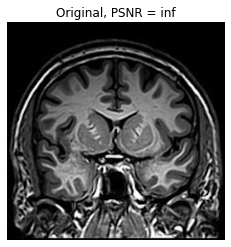

In [6]:
algo.display(algo.original, "Original")

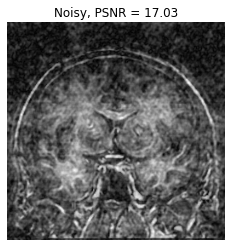

In [7]:
algo.display(algo.noisy, "Noisy")

### Cross Validation + Testing for SVRG

In [376]:
T1 = list(range(40, 100, 10))
T2 = list(range(1, 11, 1))
iters = list(product(T1, T2))

In [377]:
def f(iters):
    return peak_signal_noise_ratio(algo.original, 
                            algo.svrg(denoiser='nlm', eta=0.1, T1=iters[0], T2=iters[1], 
                                      batch_size=100, FILTER=0.015, 
                                      patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, 
                                      orig=algo.original)[0]), (iters[0], iters[1])

with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, iters), total=len(iters)))

100%|██████████| 60/60 [05:30<00:00,  5.52s/it]


In [378]:
results.sort(reverse=True)

results[0]

(25.922449611671755, (50, 10))

Total time:  32.40323352813721


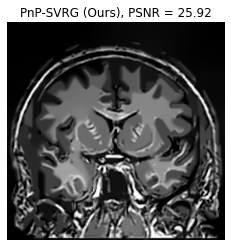

In [8]:
start = time.time()
out_svrg_nlm, time_svrg_nlm, psnr_svrg_nlm = algo.svrg(denoiser='nlm', eta=0.1, T1=50, T2=10, batch_size=100, FILTER=0.015, 
                                           patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)
print("Total time: ", time.time()-start)

algo.display(out_svrg_nlm, "PnP-SVRG (Ours)")

In [402]:
eta = list(map(float, np.linspace(1.5, 2, 20)))
T1 = list(range(1, 5, 1))

iters = list(product(eta, T1))

In [403]:
results = []

for e, t1 in tqdm.tqdm(iters):
    results.append((peak_signal_noise_ratio(algo1.original, 
                                           algo1.svrg(denoiser='cnn', eta=e, T1=t1, T2=1, 
                                           batch_size=100, FILTER=0.015, 
                                           patch=algo1.patch, z=algo1.noisy, MASK=algo1.mask, meas=algo1.y, 
                                           orig=algo1.original)[0]), (e, t1, 'dncnn')))
    
    results.append((peak_signal_noise_ratio(algo2.original, 
                                           algo2.svrg(denoiser='cnn', eta=e, T1=t1, T2=1, 
                                           batch_size=100, FILTER=0.015, 
                                           patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, 
                                           orig=algo2.original)[0]), (e, t1, 'dudncnn')))


  0%|          | 0/80 [00:00<?, ?it/s]<ipython-input-337-68384ad55f3f>:99: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-403-e2bcb6bcb0ff>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo1.original,
<ipython-input-403-e2bcb6bcb0ff>:10: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo2.original,
100%|██████████| 80/80 [00:07<00:00, 10.17it/s]


In [404]:
results.sort(reverse=True)

results[0]

(22.893854445206333, (1.6578947368421053, 4, 'dudncnn'))

Total time:  0.16410493850708008


<ipython-input-3-68384ad55f3f>:99: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-3-68384ad55f3f>:47: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_out = peak_signal_noise_ratio(self.original, output)


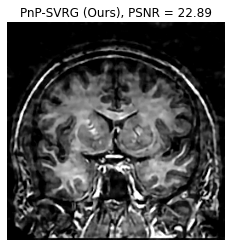

In [9]:
start = time.time()
out_svrg_cnn, time_svrg_cnn, psnr_svrg_cnn = algo2.svrg(denoiser='cnn', eta=1.66, T1=4, T2=1, batch_size=100, FILTER=0.015, 
                                           patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, orig=algo2.original)
print("Total time: ", time.time()-start)


algo.display(out_svrg_cnn, "PnP-SVRG (Ours)")

### Cross Validation + Testing for GD

In [416]:
eta = list(map(float, np.linspace(0, 1, 5)))
T = list(range(10, 1000, 50))

iters = list(product(eta, T))

In [417]:
def f(iters):
    return peak_signal_noise_ratio(algo.original, algo.gd(denoiser='nlm', eta=iters[0], 
                                                          T=iters[1], FILTER=0.015,
                                                          patch=algo.patch, z=algo.noisy, 
                                                          MASK=algo.mask, 
                                                          meas=algo.y, orig=algo.original)[0]), (iters[0], iters[1]) 
with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, iters), total=len(iters)))

100%|██████████| 100/100 [10:47<00:00,  6.47s/it]


In [418]:
results.sort(reverse=True)

results[0]

(29.721464544892875, (0.75, 610))

Total time:  31.019789457321167


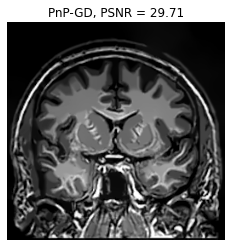

In [10]:
start = time.time()
out_gd_nlm, time_gd_nlm, psnr_gd_nlm = algo.gd(denoiser='nlm', eta=0.75, T=560, FILTER=0.015,
                                       patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)
print("Total time: ", time.time()-start)

algo.display(out_gd_nlm, "PnP-GD")

In [430]:
eta = list(map(float, np.linspace(1.5, 2, 10)))
T1 = list(range(1, 20, 2))

iters = list(product(eta, T1))

In [431]:
results = []

for e, t1 in tqdm.tqdm(iters):
    results.append((peak_signal_noise_ratio(algo1.original, 
                                           algo1.gd(denoiser='cnn', eta=e, T=t1, FILTER=0.015,
                                           patch=algo1.patch, z=algo1.noisy, MASK=algo1.mask, meas=algo1.y, 
                                           orig=algo1.original)[0]), (e, t1, 'dncnn')))
    
    results.append((peak_signal_noise_ratio(algo2.original, 
                                           algo2.gd(denoiser='cnn', eta=e, T=t1, FILTER=0.015,
                                           patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, 
                                           orig=algo2.original)[0]), (e, t1, 'dudncnn')))  
    

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-337-68384ad55f3f>:136: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-431-e80ef75d1e0d>:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo1.original,
<ipython-input-431-e80ef75d1e0d>:9: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo2.original,
100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


In [432]:
results.sort(reverse=True)

results[0]

(22.41311524491937, (1.5, 5, 'dudncnn'))

Total time:  0.08558797836303711


<ipython-input-3-68384ad55f3f>:136: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-3-68384ad55f3f>:47: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_out = peak_signal_noise_ratio(self.original, output)


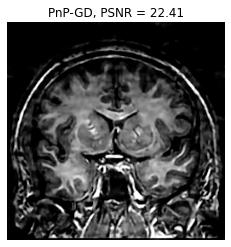

In [11]:
start = time.time()
out_gd_cnn, time_gd_cnn, psnr_gd_cnn = algo2.gd(denoiser='cnn', eta=1.5, T=5, FILTER=0.015,
                                       patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, orig=algo2.original)
print("Total time: ", time.time()-start)

algo.display(out_gd_cnn, "PnP-GD")

### Cross Validation + Testing for SGD

Total time:  11.533499717712402


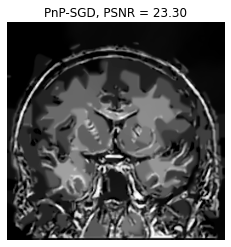

In [12]:
start = time.time()
out_sgd_nlm, time_sgd_nlm, psnr_sgd_nlm = algo.sgd(denoiser='nlm', eta=1.5, T=200, batch_size=1000, FILTER=0.015,
                                                   patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)
print("Total time: ", time.time()-start)

algo.display(out_sgd_nlm, "PnP-SGD")

In [457]:
eta = list(map(float, np.linspace(0, 1, 20)))
T1 = list(range(1, 10, 1))

iters = list(product(eta, T1))

results = []

for e, t1 in tqdm.tqdm(iters):
    results.append((peak_signal_noise_ratio(algo1.original, algo1.sgd(denoiser='cnn', eta=e, T=t1, 
                                                                      batch_size=100, 
                                                      FILTER=0.015, patch=algo1.patch, z=algo1.noisy, 
                                                      MASK=algo1.mask, meas=algo1.y, 
                                                      orig=algo1.original)[0]), (e, t1, 'dncnn')))
    
    results.append((peak_signal_noise_ratio(algo2.original, algo2.sgd(denoiser='cnn', eta=e, T=t1, 
                                                                      batch_size=100, 
                                                      FILTER=0.015, patch=algo2.patch, z=algo2.noisy, 
                                                      MASK=algo2.mask, meas=algo2.y, 
                                                      orig=algo2.original)[0]), (e, t1, 'dudncnn')))  
    
results.sort(reverse=True)

results[0]

  0%|          | 0/180 [00:00<?, ?it/s]<ipython-input-337-68384ad55f3f>:172: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-457-b27b6940f9d1>:9: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo1.original, algo1.sgd(denoiser='cnn', eta=e, T=t1,
<ipython-input-457-b27b6940f9d1>:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  results.append((peak_signal_noise_ratio(algo2.original, algo2.sgd(denoiser='cnn', eta=e, T=t1,
100%|██████████| 180/180 [00:19<00:00,  9.16it/s]


(18.98465834987288, (0.21052631578947367, 2, 'dudncnn'))

Total time:  0.0298919677734375


<ipython-input-3-68384ad55f3f>:172: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-3-68384ad55f3f>:47: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_out = peak_signal_noise_ratio(self.original, output)


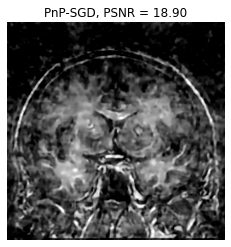

In [58]:
start = time.time()
out_sgd_cnn, time_sgd_cnn, psnr_sgd_cnn = algo2.sgd(denoiser='cnn', eta=0.25, T=2, batch_size=100, FILTER=0.015,
                                       patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, orig=algo2.original)
print("Total time: ", time.time()-start)

algo.display(out_sgd_cnn, "PnP-SGD")

### Cross Validation + Testing for ADMM

In [469]:
alpha = list(map(float, np.linspace(1.5, 2.5, 5)))
T = list(range(10, 50, 5))

iters = list(product(alpha, T))

In [470]:
def f(iters):
    return peak_signal_noise_ratio(algo.original, algo.admm(denoiser='nlm', alpha=iters[0], 
                                                            T=iters[1], FILTER=0.015,
                                                            patch=algo.patch, z=algo.noisy, 
                                                            MASK=algo.mask, meas=algo.y, 
                                                            orig=algo.original)[0]), (iters[0], iters[1])

with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, iters), total=len(iters)))

100%|██████████| 40/40 [02:13<00:00,  3.33s/it]


In [471]:
results.sort(reverse=True)

results[0]

(18.20436852819431, (1.5, 40))

Total time:  11.108851909637451


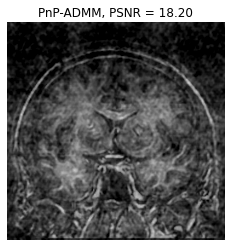

In [14]:
start = time.time()
out_admm_nlm, time_admm_nlm, psnr_admm_nlm = algo.admm(denoiser='nlm', alpha=1.5, T=40, FILTER=0.015,
                                           patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)
print("Total time: ", time.time()-start)

algo.display(out_admm_nlm, "PnP-ADMM")

<ipython-input-3-68384ad55f3f>:238: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))


Total time:  3.699709892272949


<ipython-input-3-68384ad55f3f>:47: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_out = peak_signal_noise_ratio(self.original, output)


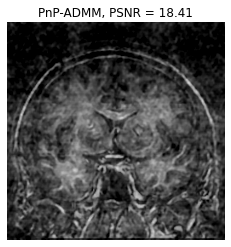

In [15]:
start = time.time()
out_admm_cnn, time_admm_cnn, psnr_admm_cnn = algo2.admm(denoiser='cnn', alpha=0.9, T=15, FILTER=0.015,
                                           patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, orig=algo2.original)
print("Total time: ", time.time()-start)

algo.display(out_admm_cnn, "PnP-ADMM")

### Cross Validation + Testing for LSVRG

In [190]:
eta = list(map(float, np.linspace(0, 1, 5)))
T = list(range(10, 50, 4))
p = list(map(float, np.linspace(0.1, 0.8, 5)))

iters = list(product(eta, T, p))

In [191]:
def f(iters):
    return peak_signal_noise_ratio(algo.original, algo.lsvrg(denoiser='nlm', eta=iters[0], T=iters[1], 
                                                             batch_size=30000, FILTER=0.015, p=iters[2],
                                                             patch=algo.patch, z=algo.noisy, 
                                                             MASK=algo.mask, meas=algo.y, 
                                                             orig=algo.original)[0]), (iters[0], iters[1], 
                                                                                       iters[2])

with MP.Pool(processes=5) as pool:
    results = list(tqdm.tqdm(pool.imap(f, iters), total=len(iters)))

100%|██████████| 250/250 [00:38<00:00,  6.51it/s]


In [192]:
results.sort(reverse=True)

results[0]

(17.826290492214152, (0.25, 46, 0.8))

Total time:  33.70974326133728


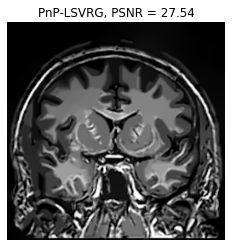

In [16]:
start = time.time()
out_lsvrg_nlm, time_lsvrg_nlm, psnr_lsvrg_nlm = algo.lsvrg(denoiser='nlm', eta=0.25, T=500, batch_size=30000, 
                                               FILTER=0.015, p=0.8,
                                               patch=algo.patch, z=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)
print("Total time: ", time.time()-start)

algo.display(out_lsvrg_nlm, "PnP-LSVRG")

Total time:  0.09650897979736328


<ipython-input-3-68384ad55f3f>:288: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_per_iter.append(peak_signal_noise_ratio(orig, z))
<ipython-input-3-68384ad55f3f>:47: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_out = peak_signal_noise_ratio(self.original, output)


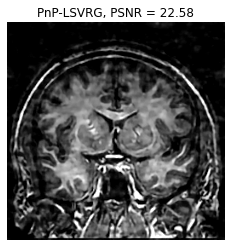

In [41]:
start = time.time()
out_lsvrg_cnn, time_lsvrg_cnn, psnr_lsvrg_cnn = algo2.lsvrg(denoiser='cnn', eta=1.7, T=4, batch_size=30000, 
                                               FILTER=0.015, p=1,
                                               patch=algo2.patch, z=algo2.noisy, MASK=algo2.mask, meas=algo2.y, orig=algo2.original)
print("Total time: ", time.time()-start)

algo.display(out_lsvrg_cnn, "PnP-LSVRG")

In [ ]:
# out_kat, time_kat, psnr_kat = algo.katyusha(T=10, theta1=0.1, theta2=0.1, p=0.2, mu=1, L=1, batch_size=30000, FILTER=0.015,
#                                             patch=algo.patch, x_init=algo.noisy, MASK=algo.mask, meas=algo.y, orig=algo.original)

# algo.display(out_kat, "PnP-Katyusha")

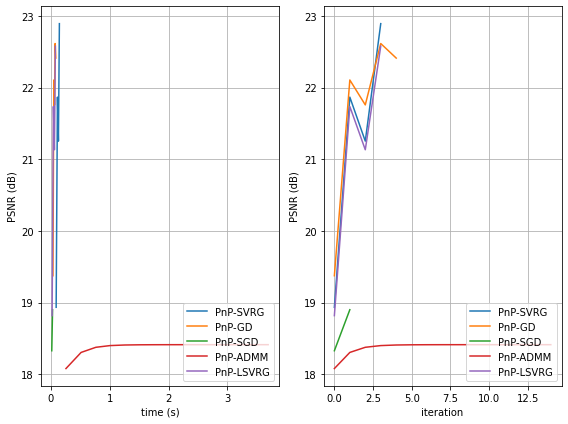

In [65]:
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_svrg_cnn), psnr_svrg_cnn, label='PnP-SVRG')
psnr_ax[0].plot(np.cumsum(time_gd_cnn), psnr_gd_cnn, label='PnP-GD')
psnr_ax[0].plot(np.cumsum(time_sgd_cnn), psnr_sgd_cnn, label='PnP-SGD')
psnr_ax[0].plot(np.cumsum(time_admm_cnn), psnr_admm_cnn, label='PnP-ADMM')
psnr_ax[0].plot(np.cumsum(time_lsvrg_cnn), psnr_lsvrg_cnn, label='PnP-LSVRG')

psnr_ax[1].plot(range(len(time_svrg_cnn)), psnr_svrg_cnn, label='PnP-SVRG')
psnr_ax[1].plot(range(len(psnr_gd_cnn)), psnr_gd_cnn, label='PnP-GD')
psnr_ax[1].plot(range(len(psnr_sgd_cnn)), psnr_sgd_cnn, label='PnP-SGD')
psnr_ax[1].plot(range(len(psnr_admm_cnn)), psnr_admm_cnn, label='PnP-ADMM')
psnr_ax[1].plot(range(len(psnr_lsvrg_cnn)), psnr_lsvrg_cnn, label='PnP-LSVRG')

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()